In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import Data

In [3]:
df = pd.read_csv(r'C:\Users\pipis\Documents\CEID\Διπλωματική\Jupyter_Notebook\Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv(r'C:\Users\pipis\Documents\CEID\Διπλωματική\Jupyter_Notebook\Corona_NLP_test.csv')

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis

In [6]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')


Do we have dublicate Tweets ?

In [7]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


No dublicates found

Set plots

In [9]:
#set seed for reproducibility   
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

C:\Users\pipis\AppData\Local\Temp\ipykernel_5532\3964033173.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

Tweets Deep Cleaning

In [10]:
df = df[['OriginalTweet','Sentiment']]                              #keep only the columns we need
df_test = df_test[['OriginalTweet','Sentiment']]                    #keep only the columns we need

Define custom functions to clean the text of the tweets

In [11]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [12]:
#remove emojis

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

texts_new = [remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emoji(t))))) for t in df.OriginalTweet]
texts_new_test = [remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emoji(t))))) for t in df_test.OriginalTweet]



Cleaned Versions

In [13]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

Display the cleaned text

In [14]:
df['text_clean'].head()


0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [15]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [16]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

Check if we cleaned too much text or cleaned all the text from a tweet

In [17]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)


df['text_len'] = text_len

In [18]:
text_len_test = []                                
for text in df_test.text_clean:                      
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

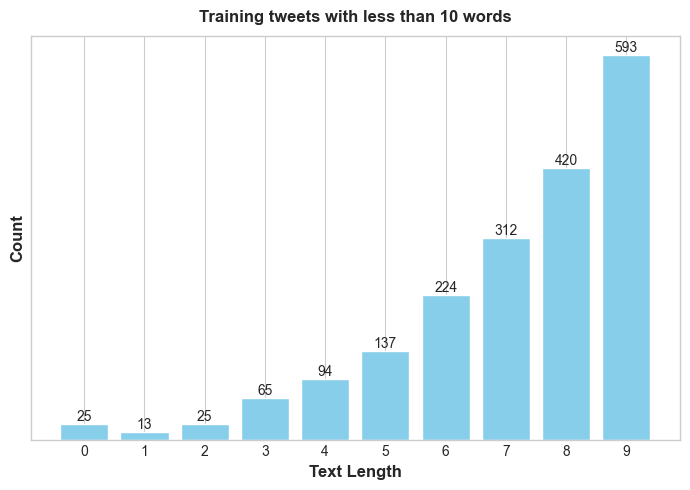

In [19]:
#plot the distribution of the tweets length

plt.figure(figsize=(7, 5))
filtered_df = df[df['text_len'] < 10]
counts = filtered_df['text_len'].value_counts().sort_index()

plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Training tweets with less than 10 words')
plt.ylabel('Count')
plt.xlabel('Text Length')
plt.xticks(counts.index)
plt.yticks([])

for i, value in enumerate(counts.values):
    plt.text(counts.index[i], value, str(value), ha='center', va='bottom')

plt.show()


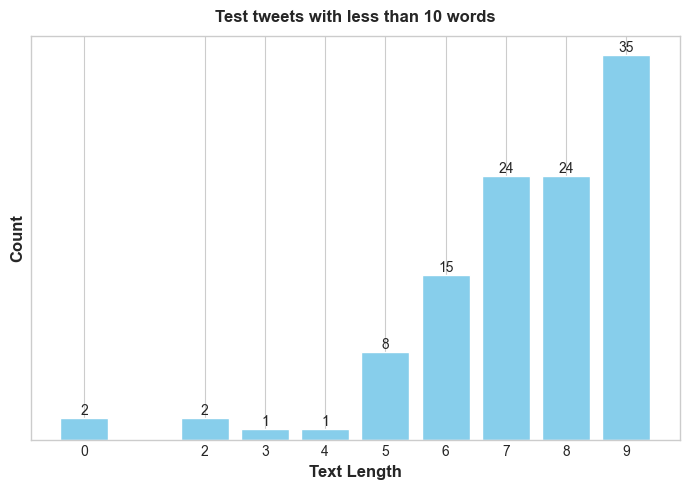

In [20]:
#Plot the distribution of the number of words in the test set

plt.figure(figsize=(7, 5))
filtered_df_test = df_test[df_test['text_len'] < 10]
counts_test = filtered_df_test['text_len'].value_counts().sort_index()

plt.bar(counts_test.index, counts_test.values, color='skyblue')
plt.title('Test tweets with less than 10 words')
plt.ylabel('Count')
plt.xlabel('Text Length')
plt.xticks(counts_test.index)
plt.yticks([])

for i, value in enumerate(counts_test.values):
    plt.text(counts_test.index[i], value, str(value), ha='center', va='bottom')

plt.show()

A lot of clean tweets have 0 words, this means that some tweets contained only mentions, hashtags and links, which have been removed.
We drop empty tweets and those with less than 5 words

In [21]:
print(f" DF SHAPE: {df.shape}")                        
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [22]:
df = df[df['text_len'] > 4]

In [23]:
df_test = df_test[df_test['text_len'] > 4]

In [24]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


Training data deeper cleaning

Ιmport the BERT tokenizer

In [25]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')          #BERT

token_lens = []                                                             #tokenize the tweets and find the max length

for txt in df['text_clean'].values:                                                            
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)              
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


 The long tokenized sentences must be on another language so we drop them
 

In [26]:
token_lens = []                                                             #reset token_lens                                                   

for i,txt in enumerate(df['text_clean'].values):                            #iterate through the tweets
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)         #tokenize the tweet
    token_lens.append(len(tokens))                                          #append the length of the tokenized tweet to token_lens
    if len(tokens)>80:                                                      #if the length of the tokenized tweet is greater than 80    
        print(f"INDEX: {i}, TEXT: {txt}")                                   #print the index and the text of the tweet             

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [27]:
df['token_lens'] = token_lens
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)


,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [28]:
df = df.iloc[12:]                   #remove the 12 rows with the longest tweets
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


Shuffle dataset and reset the index

In [29]:
df = df.sample(frac=1).reset_index(drop=True)                           #shuffle the dataset

Test data deeper cleaning

In [30]:
token_lens_test = []                                                            #tokenize test set

for txt in df_test['text_clean'].values:                                        #for each tweet    
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)             #encode text
    token_lens_test.append(len(tokens))                                         #append length of tokens    
    
max_len=np.max(token_lens_test)                                                 #find max length of tokens    

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")                              #print max length of tokens               

MAX TOKENIZED SENTENCE LENGTH: 96


In [31]:
token_lens_test = []                                                                #check for tweets with more than 80 tokens

for i,txt in enumerate(df_test['text_clean'].values):                               
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)                 #to check if they are valid
    token_lens_test.append(len(tokens))                                                 
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [32]:
df_test['token_lens'] = token_lens_test                                         #add token_lens column to df_test
df_test = df_test.sort_values(by='token_lens', ascending=False)                 #sort df_test by token_lens
df_test.head(10)                                                                #print first 10 rows of df_test             

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [33]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


Sentiment column analysis

In [34]:
df['Sentiment'].value_counts()

Sentiment
Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: count, dtype: int64

We will create 3 emotions Positive, Neutral and Negative

In [35]:

df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})            
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
                                                
df['Sentiment'].value_counts()

Sentiment
2    17999
0    15364
1     7560
Name: count, dtype: int64

Class Balancing by RandomOverSampler

In [36]:
ros = RandomOverSampler()                   #oversampling to balance the classes
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));   #train_x is a list of lists
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);                #train_y is a list of lists

In [37]:
train_os['Sentiment'].value_counts()        #balanced classes

Sentiment
2    17999
1    17999
0    17999
Name: count, dtype: int64

Train - Validation - Test split

In [38]:
X = train_os['text_clean'].values                                                                                 
y = train_os['Sentiment'].values                                                                                                               
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)           #train val split
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

One hot encoding, save a copy of the label encoded target columns since they could be useful for further analysis

In [39]:
y_train_le = y_train.copy()         #label encoding
y_valid_le = y_valid.copy()         #label encoding
y_test_le = y_test.copy()           #label encoding


ohe = preprocessing.OneHotEncoder()                                                     #one hot encoding
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()                 #one hot encoding
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()                 #one hot encoding
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()                   #one hot encoding

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )   #print the number of samples in each set

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


Naive Bayes Classifier

 Τokenize the tweets using CountVectorizer

In [40]:
clf = CountVectorizer()                                 #count vectorizer
X_train_cv =  clf.fit_transform(X_train)                
X_test_cv = clf.transform(X_test)

TF-IDF versions of the tokenized tweets

In [41]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)         #tf-idf
X_train_tf = tf_transformer.transform(X_train_cv)                       
X_test_tf = tf_transformer.transform(X_test_cv)

Define the Naive Bayes Classifier model

In [42]:
nb_clf = MultinomialNB()                        #naive bayes
nb_clf.fit(X_train_tf, y_train_le)              

MultinomialNB()

In [43]:
nb_pred = nb_clf.predict(X_test_tf)             #naive bayes predictions
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))
print('\tAccuracy for Naive Bayes:\n\n',accuracy_score(y_test_le,nb_pred))
print('\n\tConfusion Matrix for Naive Bayes:\n\n',confusion_matrix(y_test_le,nb_pred))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.79      0.74      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.74      0.71      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787

	Accuracy for Naive Bayes:

 0.702138896223924

	Confusion Matrix for Naive Bayes:

 [[1286  107  236]
 [ 194  270  150]
 [ 358   83 1103]]


Define RoBERTa tokenizer

In [44]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 2.78MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 2.59MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.68MB/s]
config.json: 100%|██████████| 481/481 [00:00<00:00, 482kB/s]


We check lognest tokenized sentence with roberta tokenizer

In [45]:
token_lens = []                                                                         #tokenize the tweets and find the max length

for txt in X_train:                                                                     #for each tweet
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)             #tokenize the tweet
    token_lens.append(len(tokens))                                                      #append the length of the tokenized tweet to token_lens   
max_length=np.max(token_lens)                                                           #find max length of tokens
max_length                                                                              #print max length of tokens                                            

89

Define the tokenization function

In [46]:
MAX_LEN=128


def tokenize_roberta(data,max_len=MAX_LEN) :                            #tokenize the data
    input_ids = []                                                      #initialize input_ids
    attention_masks = []                                                #initialize attention_masks                 
    for i in range(len(data)):                                          #for each tweet
        encoded = tokenizer_roberta.encode_plus(                        #encode the tweet
            data[i],                                                    #tweet
            add_special_tokens=True,                                    #add special tokens
            max_length=max_len,                                         #max length
            padding='max_length',                                       #pad to max length  
            return_attention_mask=True                                  #return attention mask                
        )
        input_ids.append(encoded['input_ids'])                          #append input_ids
        attention_masks.append(encoded['attention_mask'])               #append attention_masks
    return np.array(input_ids),np.array(attention_masks)                #return input_ids and attention_masks    

Tokenize

In [47]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)             #tokenize the tweets
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)                 
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

RoBERTa modeling

In [51]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)                           #optimizer              
    loss = tf.keras.losses.CategoricalCrossentropy()                                         #loss function
    accuracy = tf.keras.metrics.CategoricalAccuracy()                                        #accuracy metric

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')                               #input layer   
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')                         #attention mask layer
    output = bert_model([input_ids,attention_masks])                                         #output layer
    output = output[1]                                                                       #output layer 
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)                      #dense layer
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)     #model
    model.compile(opt, loss=loss, metrics=accuracy)                                          #compile model
    return model                                                                             #return model                         

In [52]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Create and show model

In [53]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)